In [ ]:
pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html

In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import os
from dgl.nn import GraphConv
import numpy as np
import torch.optim as optim
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from dgl.dataloading import GraphDataLoader
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from joblib import dump, load
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(torch.__version__)

2.3.1+cu121


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dirve_path = '/content/drive/MyDrive/Project/'
train = pd.read_csv(dirve_path + 'security_train.csv')

In [ ]:
train

,file_id,label,api,tid,index
0,1,5,LdrLoadDll,2488,0
1,1,5,LdrGetProcedureAddress,2488,1
2,1,5,LdrGetProcedureAddress,2488,2
3,1,5,LdrGetProcedureAddress,2488,3
4,1,5,LdrGetProcedureAddress,2488,4
...,...,...,...,...,...
89806688,13887,2,NtClose,2336,618
89806689,13887,2,NtClose,2336,619
89806690,13887,2,NtClose,2336,620
89806691,13887,2,NtClose,2336,621


In [ ]:
print(train.isnull().sum())

In [ ]:
train['file_id'] = train['file_id'].astype(np.int16)
train['label'] = train['label'].astype(np.int16)
train['api'] = train['api'].astype(str)
train['tid'] = train['tid'].astype(np.int16)
train['index'] = train['index'].astype(np.int16)

DataLoader

In [ ]:
api_to_idx = {api: idx for idx, api in enumerate(train['api'].unique())}

In [ ]:
train['api_idx'] = train['api'].map(api_to_idx)  # Map API names to indexes
train.sort_values(by=['file_id', 'index'], inplace=True)  # Ensure that the data within each file_id is sorted by index
file_ids = train['file_id'].unique()

In [ ]:
train_file_ids, val_file_ids = train_test_split(file_ids, test_size=0.2, random_state=42)
train_data = train[train['file_id'].isin(train_file_ids)]
val_data = train[train['file_id'].isin(val_file_ids)]

In [ ]:
train_file_ids, temp_file_ids = train_test_split(file_ids, test_size=0.3, random_state=42)

val_file_ids, test_file_ids = train_test_split(temp_file_ids, test_size=0.5, random_state=42)

train_data = train[train['file_id'].isin(train_file_ids)]
val_data = train[train['file_id'].isin(val_file_ids)]
test_data = train[train['file_id'].isin(test_file_ids)]

In [ ]:
class CustomGraphDataset(Dataset):
    def __init__(self, dataframe, api_to_idx, device):
        self.dataframe = dataframe
        self.api_to_idx = api_to_idx
        self.file_ids = dataframe['file_id'].unique()
        self.device = device

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        file_id = self.file_ids[idx]
        sub_df = self.dataframe[self.dataframe['file_id'] == file_id].reset_index(drop=True)

        g = dgl.graph(([], []), device=self.device)  # Create an empty diagram
        g.add_nodes(len(sub_df))

        apis_indices = [self.api_to_idx[api] for api in sub_df['api']]
        g.ndata['api_idx'] = torch.tensor(apis_indices, dtype=torch.long, device=self.device)  # Create node features

        thread_ids = sub_df['tid'].tolist()
        g.ndata['tid'] = torch.tensor(thread_ids, dtype=torch.long, device=self.device)  # Add thread IDs as node features

        edges_src, edges_dst = [], []
        for tid in sub_df['tid'].unique():
            tid_mask = sub_df['tid'] == tid
            tid_indices = np.where(tid_mask)[0]
            if len(tid_indices) > 1:
                edges_src.extend(tid_indices[:-1])
                edges_dst.extend(tid_indices[1:])

        g.add_edges(
            torch.tensor(edges_src, dtype=torch.long, device=self.device),
            torch.tensor(edges_dst, dtype=torch.long, device=self.device)
        )

        label = sub_df['label'].iloc[0]
        g.ndata['label'] = torch.tensor([label] * g.num_nodes(), dtype=torch.long, device=self.device)
        return g, torch.tensor(label, dtype=torch.long, device=self.device)

In [ ]:
def collate_samples(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    batched_labels = torch.stack(labels)
    return batched_graph, batched_labels

In [ ]:
train_dataset = CustomGraphDataset(train_data, api_to_idx, device)

In [ ]:
val_dataset = CustomGraphDataset(val_data, api_to_idx, device)

In [ ]:
test_dataset = CustomGraphDataset(test_data, api_to_idx, device)

In [ ]:
train_loader = GraphDataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_samples)

In [ ]:
val_loader = GraphDataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=collate_samples)

In [ ]:
test_loader = GraphDataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_samples)

GCN Model

In [ ]:
class GraphModel(nn.Module):
    def __init__(self, num_apis, embedding_dim, num_classes, allow_zero_in_degree):
        super(GraphModel, self).__init__()
        self.embedding = nn.Embedding(num_apis, embedding_dim)
        self.conv1 = GraphConv(embedding_dim, 16, allow_zero_in_degree=allow_zero_in_degree)
        self.conv2 = GraphConv(16, num_classes, allow_zero_in_degree=allow_zero_in_degree)
        self.classifier = nn.Linear(num_classes, num_classes)# This layer is used to further process the aggregated graph-level features

    def forward(self, g, return_embeds=False):
        x = self.embedding(g.ndata['api_idx'])
        x = F.relu(self.conv1(g, x))
        x = self.conv2(g, x)
        g.ndata['h'] = x # Store the characteristics of each node
        hg = dgl.mean_nodes(g, 'h')# Average the features across all nodes to get graph level features
        if return_embeds:
          return hg  # Return aggregated features for each graph
        return self.classifier(hg)# Classification of graph-level features

Train

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, patience):
    model.to(device)
    best_val_loss = np.inf
    epochs_no_improve = 0  # 用来跟踪验证损失是否已经停止改善

    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        total_loss = 0

        for batched_graph, labels in train_loader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(batched_graph)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_train_loss = total_loss / len(train_loader)

        # 验证步骤
        model.eval()  # 设置模型为评估模式
        total_val_loss = 0
        with torch.no_grad():
            for batched_graph, labels in val_loader:
                batched_graph = batched_graph.to(device)
                labels = labels.to(device)
                logits = model(batched_graph)
                val_loss = criterion(logits, labels)
                total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / len(val_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}')

        # 检查早停条件
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')  # 保存最好的模型
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch + 1} epochs!')
                break  # 停止训练

    # 加载最佳模型
    model.load_state_dict(torch.load('best_model.pth'))

In [ ]:
num_apis = len(api_to_idx)  # API索引的数量
model = GraphModel(num_apis=num_apis, embedding_dim=10, num_classes=8, allow_zero_in_degree=True)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 20
patience = 10

In [ ]:
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, patience)

In [ ]:
model_save_path = '/content/drive/MyDrive/Project/best_model.pth'

In [ ]:
torch.save(model.state_dict(), model_save_path)

In [ ]:
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

Test

In [ ]:
def evaluate(dataloader):
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for batched_graph, labels in dataloader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)

            outputs = model(batched_graph)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return total_correct / total

In [ ]:
model.to(device)
test_accuracy = evaluate(test_loader)

In [ ]:
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7558


In [ ]:
def extract_features(dataloader):
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for batched_graph, labels in dataloader:
            batched_graph = batched_graph.to(device)
            features = model(batched_graph, return_embeds=True)  # 提取特征
            all_features.append(features.cpu().numpy())  # 存储特征
            all_labels.append(labels.cpu().numpy())  # 存储标签

    return np.concatenate(all_features), np.concatenate(all_labels)

In [ ]:
train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)
test_features, test_labels = extract_features(test_loader)

In [ ]:
def save_features_label(features_path, labels_path, features, labels):
  features_path = '/content/drive/MyDrive/Project/features/' + features_path
  labels_path = '/content/drive/MyDrive/Project/labels/' + labels_path

  np.save(features_path, features)
  np.save(labels_path, labels)

In [ ]:
save_features_label('train_features.npy','train_labels.npy', train_features, train_labels)

In [ ]:
save_features_label('val_features.npy','val_labels.npy', val_features, val_labels)
save_features_label('test_features.npy','test_labels.npy', test_features, test_labels)

In [ ]:
def load_features_label(features_path, labels_path):
  features_path = '/content/drive/MyDrive/Project/features/' + features_path
  labels_path = '/content/drive/MyDrive/Project/labels/' + labels_path

  features = np.load(features_path)
  labels = np.load(labels_path)
  return features, labels

In [ ]:
train_features, train_labels = load_features_label('train_features.npy','train_labels.npy')
val_features, val_labels = load_features_label('val_features.npy','val_labels.npy')
test_features, test_labels = load_features_label('test_features.npy','test_labels.npy')

In [ ]:
train_labels

array([0, 5, 1, ..., 0, 4, 0])

In [ ]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
train_features

array([[-2.7863426 ,  1.0929561 ,  0.19866112, ...,  1.5189173 ,
         1.3572495 ,  2.8466122 ],
       [-1.6078061 ,  0.34045684, -0.3316099 , ...,  1.9464468 ,
         0.0520192 ,  0.7229677 ],
       [-0.38655454, -0.93857294, -0.48164195, ...,  0.68538797,
        -1.1652526 , -0.7453965 ],
       ...,
       [-1.4786471 ,  0.5126234 ,  0.45795298, ...,  1.8214818 ,
         0.8521397 ,  2.5416162 ],
       [-0.04052667, -2.005582  ,  0.38119894, ..., -0.06919952,
        -1.6395158 ,  0.09374472],
       [-2.7388089 ,  1.1816062 ,  0.2791612 , ...,  2.2478292 ,
         1.0634265 ,  2.4594162 ]], dtype=float32)

In [ ]:
def train_classifier(model, parameter_dict, x_train, y_train):
    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(model, parameter_dict, cv=5, scoring=make_scorer(accuracy_score))
    grid_search.fit(x_train, y_train)

    # Print the best parameter and best score obtained
    print(f'The Best Parameter: {grid_search.best_params_}')
    print(f'The Best Score: {grid_search.best_score_}')

    return grid_search.best_estimator_

In [ ]:
def test_confusion_matrix(model, x_test, y_test, train_labels):
    y_pred = model.predict(x_test)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(train_labels)))
    plt.xticks(tick_marks, np.unique(train_labels), rotation=45)
    plt.yticks(tick_marks, np.unique(train_labels))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
def save_model(model, filename):

    dump(model, filename)
    print(f"Model saved to {filename}")

In [ ]:
def load_model(filename):

    model = load(filename)
    print(f"Model loaded from {filename}")
    return model

regression, decision Tree, Boost, GLM, CTree, Random Forest, Artificial Neural Network

LogisticRegression

In [ ]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
log_params = {
    'fit_intercept': [True, False],
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000]  # 增加迭代次数
}
best_clf = train_classifier(LogisticRegression(), log_params, train_features_scaled, train_labels)
#1m8s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The Best Parameter: {'C': 10, 'fit_intercept': True, 'max_iter': 1000, 'solver': 'saga'}
The Best Score: 0.7551440329218108


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
test_features_scaled = scaler.fit_transform(test_features)
y_pred_lr = best_clf.predict(test_features_scaled)

In [ ]:
print(classification_report(test_labels, y_pred_lr, target_names=np.unique(train_labels).astype(str)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       745
           1       0.86      0.80      0.83        74
           2       0.79      0.78      0.79       190
           3       0.48      0.69      0.57       116
           4       0.00      0.00      0.00        14
           5       0.80      0.80      0.80       635
           6       0.45      0.16      0.24        79
           7       0.52      0.48      0.50       231

    accuracy                           0.75      2084
   macro avg       0.59      0.57      0.57      2084
weighted avg       0.74      0.75      0.74      2084



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


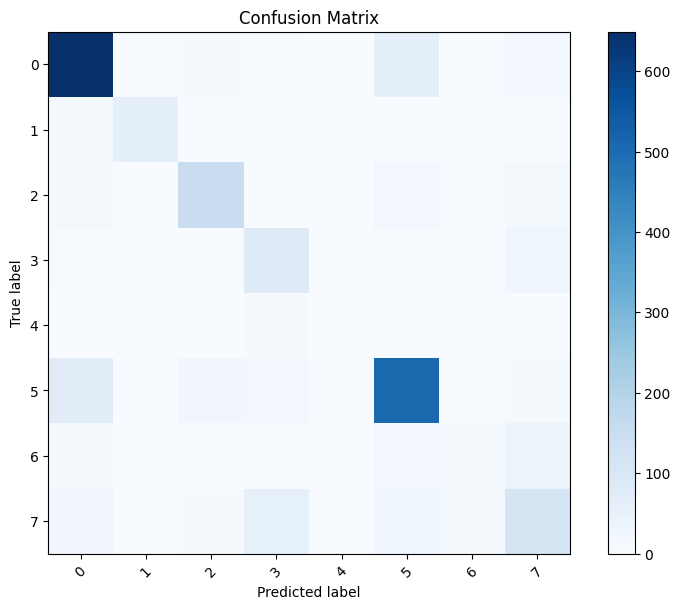

In [ ]:
test_confusion_matrix(best_clf, test_features_scaled, test_labels, train_labels)

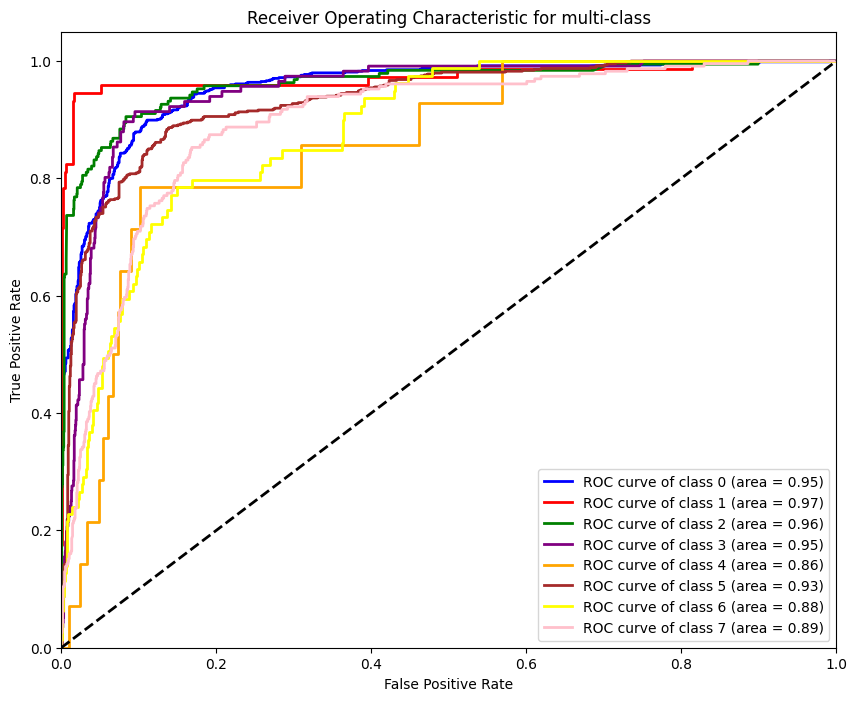

In [ ]:
test_ROC_curve_multiclass(best_clf, test_features_scaled, test_labels, np.unique(train_labels))

RandomForestClassifier

In [ ]:
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20, 30]}
best_rf = train_classifier(RandomForestClassifier(random_state=42), rf_params, train_features, train_labels)

The Best Parameter: {'max_depth': 20, 'n_estimators': 200}
The Best Score: 0.8452674897119342


In [ ]:
y_pred_rf = best_rf.predict(test_features)

In [ ]:
accuracy = accuracy_score(test_labels, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.8498080614203455


In [ ]:
print(classification_report(test_labels, y_pred_rf, target_names=np.unique(train_labels).astype(str)))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       745
           1       0.93      0.93      0.93        74
           2       0.92      0.88      0.90       190
           3       0.56      0.77      0.64       116
           4       0.67      0.14      0.24        14
           5       0.92      0.89      0.90       635
           6       0.61      0.52      0.56        79
           7       0.68      0.55      0.61       231

    accuracy                           0.85      2084
   macro avg       0.77      0.70      0.71      2084
weighted avg       0.85      0.85      0.85      2084



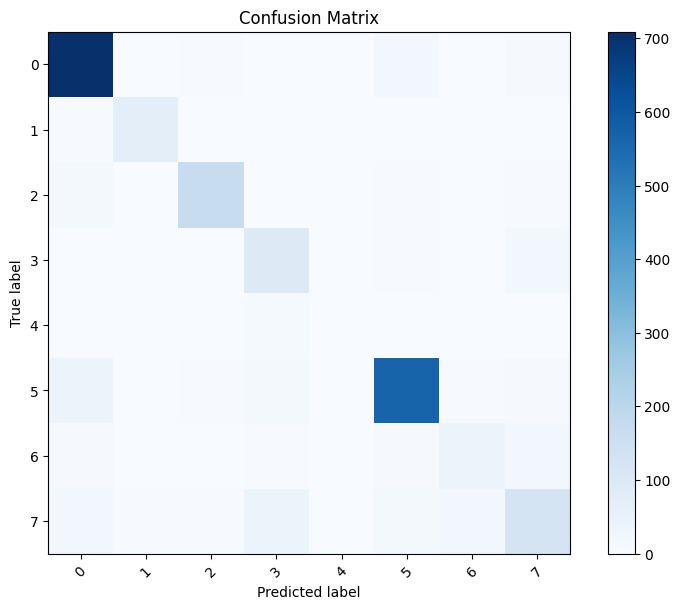

In [ ]:
test_confusion_matrix(best_rf, test_features, test_labels, train_labels)

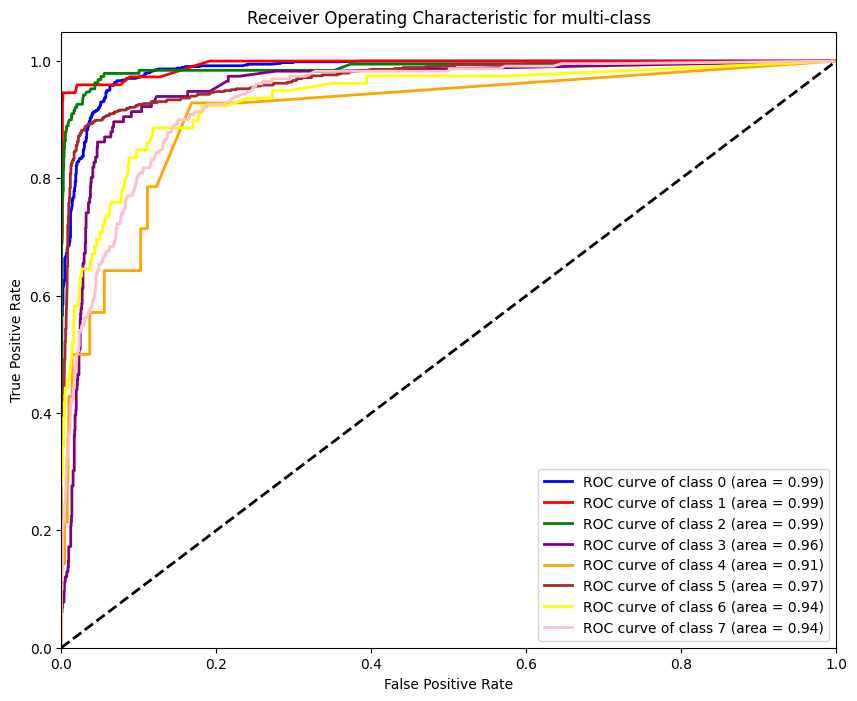

In [ ]:
test_ROC_curve_multiclass(best_rf, test_features, test_labels, np.unique(train_labels))

DecisionTreeClassifier

In [ ]:
dt_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
best_dt = train_classifier(DecisionTreeClassifier(random_state=42), dt_params, train_features, train_labels)

The Best Parameter: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
The Best Score: 0.7988683127572016


In [ ]:
y_pred_dt = best_dt.predict(test_features)

In [ ]:
print(classification_report(test_labels, y_pred_dt, target_names=np.unique(train_labels).astype(str)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       745
           1       0.90      0.88      0.89        74
           2       0.80      0.85      0.83       190
           3       0.49      0.73      0.59       116
           4       0.40      0.14      0.21        14
           5       0.90      0.82      0.86       635
           6       0.52      0.43      0.47        79
           7       0.59      0.52      0.55       231

    accuracy                           0.79      2084
   macro avg       0.68      0.66      0.66      2084
weighted avg       0.80      0.79      0.79      2084



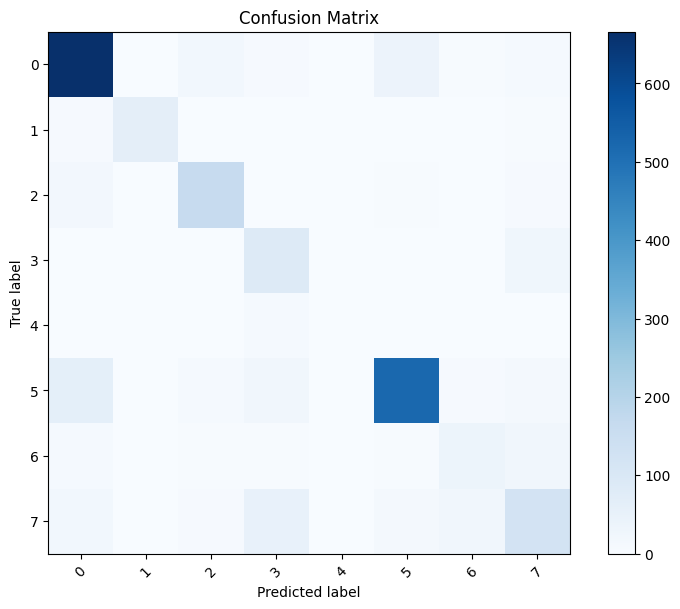

In [ ]:
test_confusion_matrix(best_dt, test_features, test_labels, train_labels)

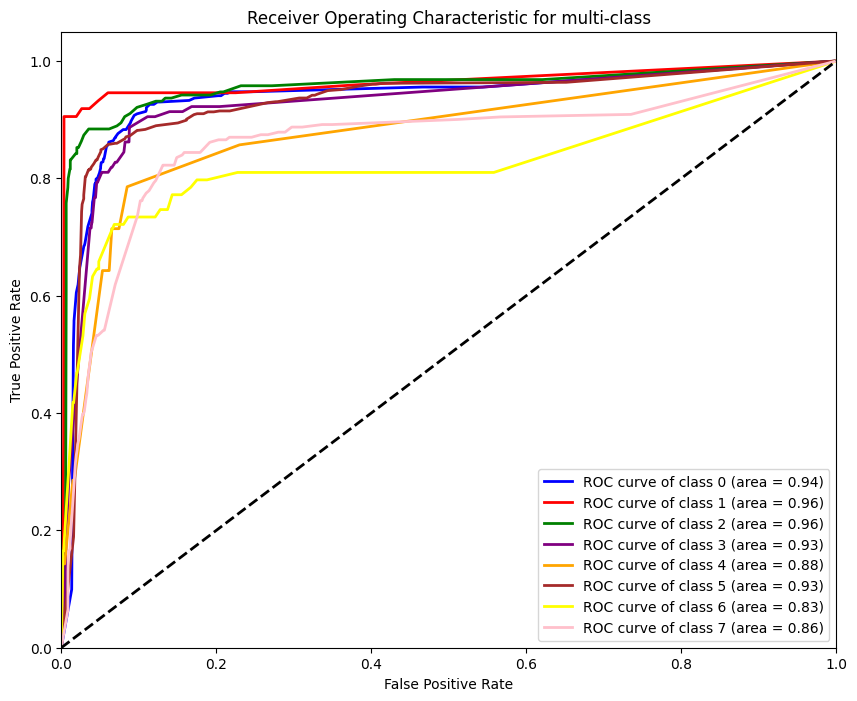

In [ ]:
test_ROC_curve_multiclass(best_dt, test_features, test_labels, np.unique(train_labels))

GradientBoostingClassifier

In [ ]:
gb_params = {
    'n_estimators': [100, 200],  # Number of trees
    'learning_rate': [0.05, 0.1],  # learning rate
    'max_depth': [3, 5],  # Maximum depth
    'min_samples_split': [2],  # Minimum Sample Segmentation
    'min_samples_leaf': [1]  # Minimum sample leaf node
}
# Setting up early stops
best_GBC = train_classifier(GradientBoostingClassifier(random_state=42, n_estimators=300, validation_fraction=0.1, n_iter_no_change=10, tol=0.01), gb_params, train_features, train_labels)

The Best Parameter: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
The Best Score: 0.8083333333333333


In [ ]:
y_pred_gbc = best_GBC.predict(test_features)

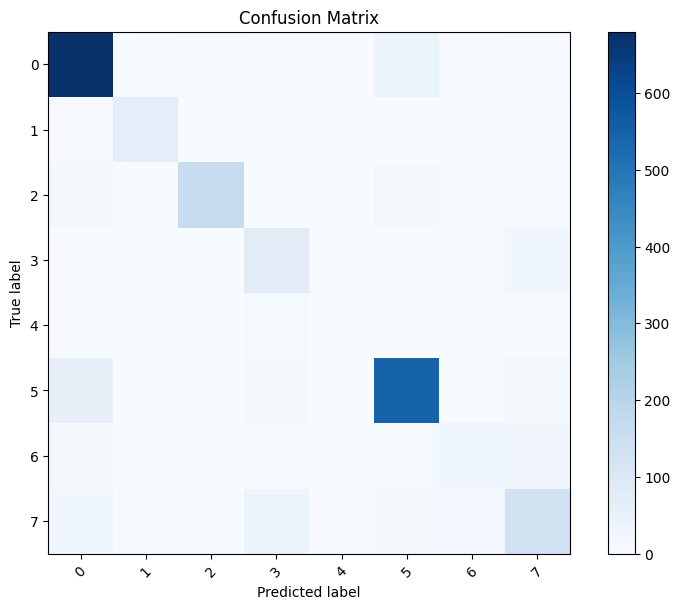

In [ ]:
test_confusion_matrix(best_GBC, test_features, test_labels, train_labels)

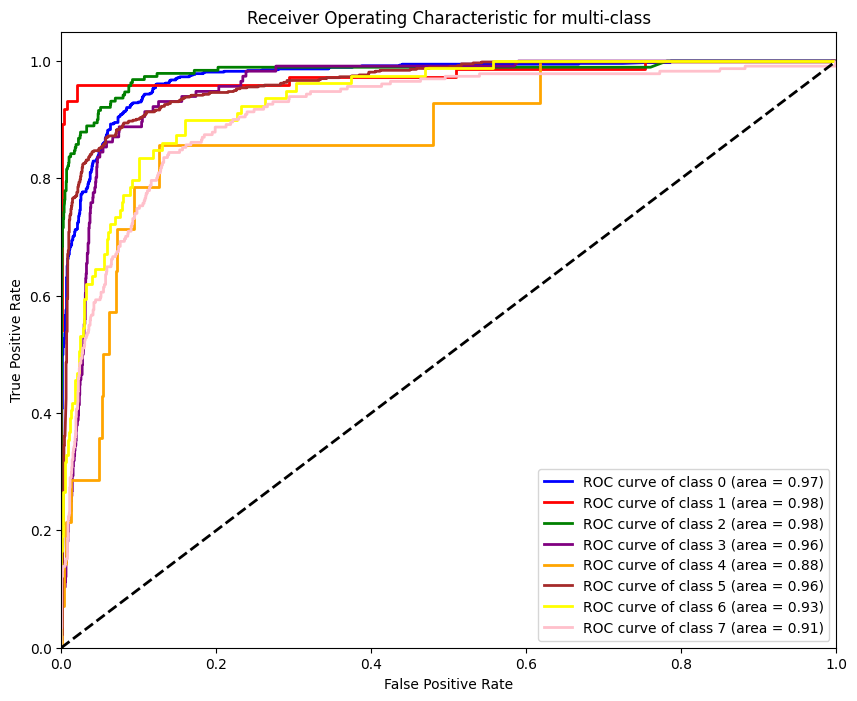

In [ ]:
test_ROC_curve_multiclass(best_GBC, test_features, test_labels, np.unique(train_labels))

MLP

In [ ]:
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [500, 1000]
}
best_ann = train_classifier(MLPClassifier(random_state=42), mlp_params, train_features, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

The Best Parameter: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'sgd'}
The Best Score: 0.8218106995884774


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
y_pred_ann = best_ann.predict(test_features)

In [ ]:
print(classification_report(test_labels, y_pred_ann, target_names=np.unique(train_labels).astype(str)))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       745
           1       0.93      0.89      0.91        74
           2       0.83      0.88      0.85       190
           3       0.52      0.75      0.61       116
           4       0.00      0.00      0.00        14
           5       0.90      0.86      0.88       635
           6       0.52      0.47      0.49        79
           7       0.63      0.54      0.58       231

    accuracy                           0.82      2084
   macro avg       0.65      0.66      0.65      2084
weighted avg       0.82      0.82      0.82      2084



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


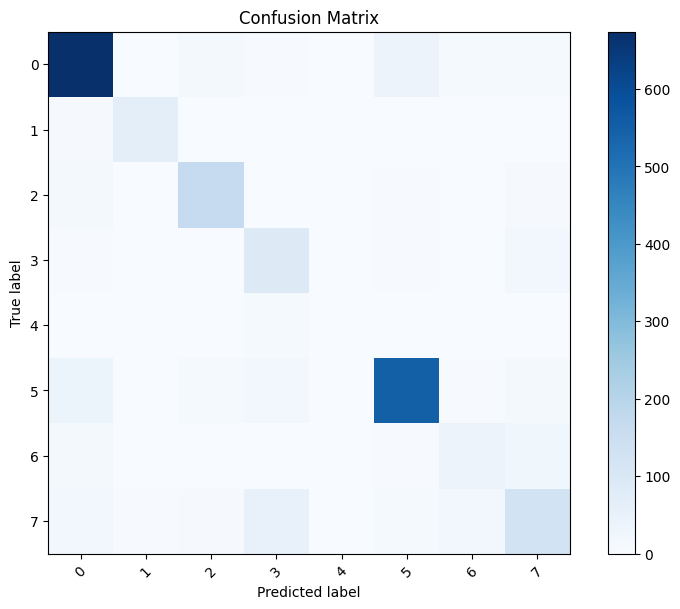

In [ ]:
test_confusion_matrix(best_ann, test_features, test_labels, train_labels)

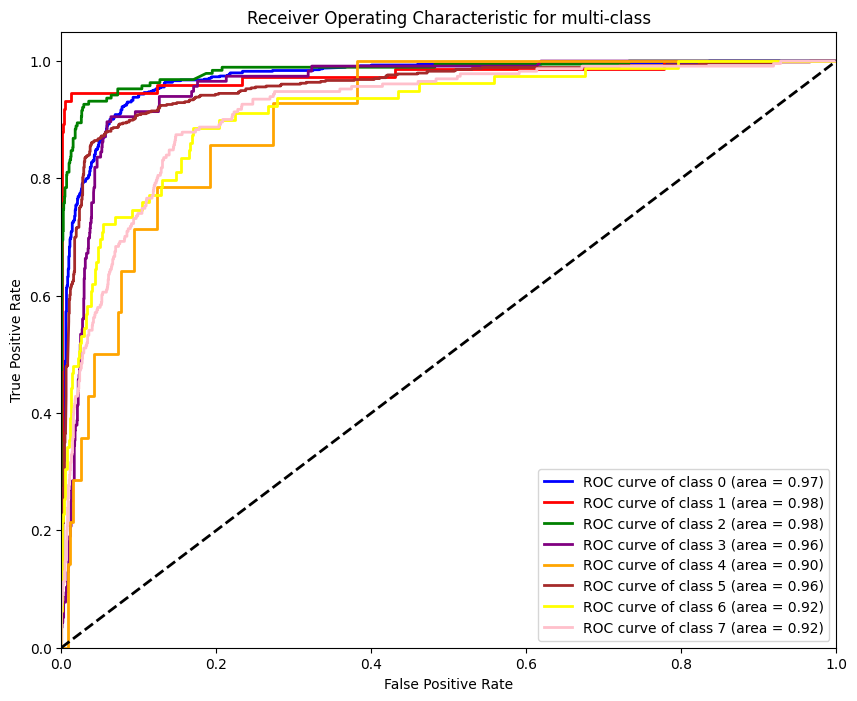

In [ ]:
test_ROC_curve_multiclass(best_ann, test_features, test_labels, np.unique(train_labels))

Evalution

In [ ]:
report_lr = classification_report(test_labels, y_pred_lr, target_names=np.unique(train_labels).astype(str), output_dict=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
report_rf = classification_report(test_labels, y_pred_rf, target_names=np.unique(train_labels).astype(str), output_dict=True)

In [ ]:
report_dt = classification_report(test_labels, y_pred_dt, target_names=np.unique(train_labels).astype(str), output_dict=True)

In [ ]:
report_ann = classification_report(test_labels, y_pred_ann, target_names=np.unique(train_labels).astype(str), output_dict=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
report_gbc = classification_report(test_labels, y_pred_gbc , target_names=np.unique(train_labels).astype(str), output_dict=True)

In [ ]:
df_lr = pd.DataFrame(report_lr).transpose()
df_rf = pd.DataFrame(report_rf).transpose()
df_dt = pd.DataFrame(report_dt).transpose()
df_ann = pd.DataFrame(report_ann).transpose()

In [ ]:
df_gbc = pd.DataFrame(report_gbc).transpose()

In [ ]:
dfs = [df_lr, df_rf, df_dt, df_ann, df_gbc]
for df in dfs:
    df.set_index(df.index.str.strip(), inplace=True)
df_combined = pd.concat(dfs, axis=1, keys=['LR', 'RF', 'DT', 'ANN', 'GBC'])

print(df_combined)

                    LR                                         RF            \
             precision    recall  f1-score      support precision    recall   
0             0.828863  0.871141  0.849476   745.000000  0.894073  0.951678   
1             0.855072  0.797297  0.825175    74.000000  0.932432  0.932432   
2             0.792553  0.784211  0.788360   190.000000  0.918033  0.884211   
3             0.484848  0.689655  0.569395   116.000000  0.556250  0.767241   
4             0.000000  0.000000  0.000000    14.000000  0.666667  0.142857   
5             0.795597  0.796850  0.796223   635.000000  0.917342  0.891339   
6             0.448276  0.164557  0.240741    79.000000  0.611940  0.518987   
7             0.518692  0.480519  0.498876   231.000000  0.679144  0.549784   
accuracy      0.751919  0.751919  0.751919     0.751919  0.849808  0.849808   
macro avg     0.590488  0.573029  0.571031  2084.000000  0.771985  0.704816   
weighted avg  0.742822  0.751919  0.743581  2084.000

In [ ]:
def combined_graphs(df_combined, str):
  parameter_lr = df_combined['LR'][str]
  parameter_rf = df_combined['RF'][str]
  parameter_dt = df_combined['DT'][str]
  parameter_ann = df_combined['ANN'][str]
  parameter_gbc = df_combined['GBC'][str]

  df_parameters = pd.DataFrame({
    'LR': parameter_lr,
    'RF': parameter_rf,
    'DT': parameter_dt,
    'ANN': parameter_ann,
    'GBC': parameter_gbc
})

  ax = df_parameters.plot(kind='bar', figsize=(14, 8))
  ax.set_xlabel('Class')
  ax.set_ylabel(str)
  ax.set_title(str + 'Comparison Across Different Models')
  ax.legend(title='Models')

  plt.xticks(rotation=0)
  plt.tight_layout()
  plt.show()

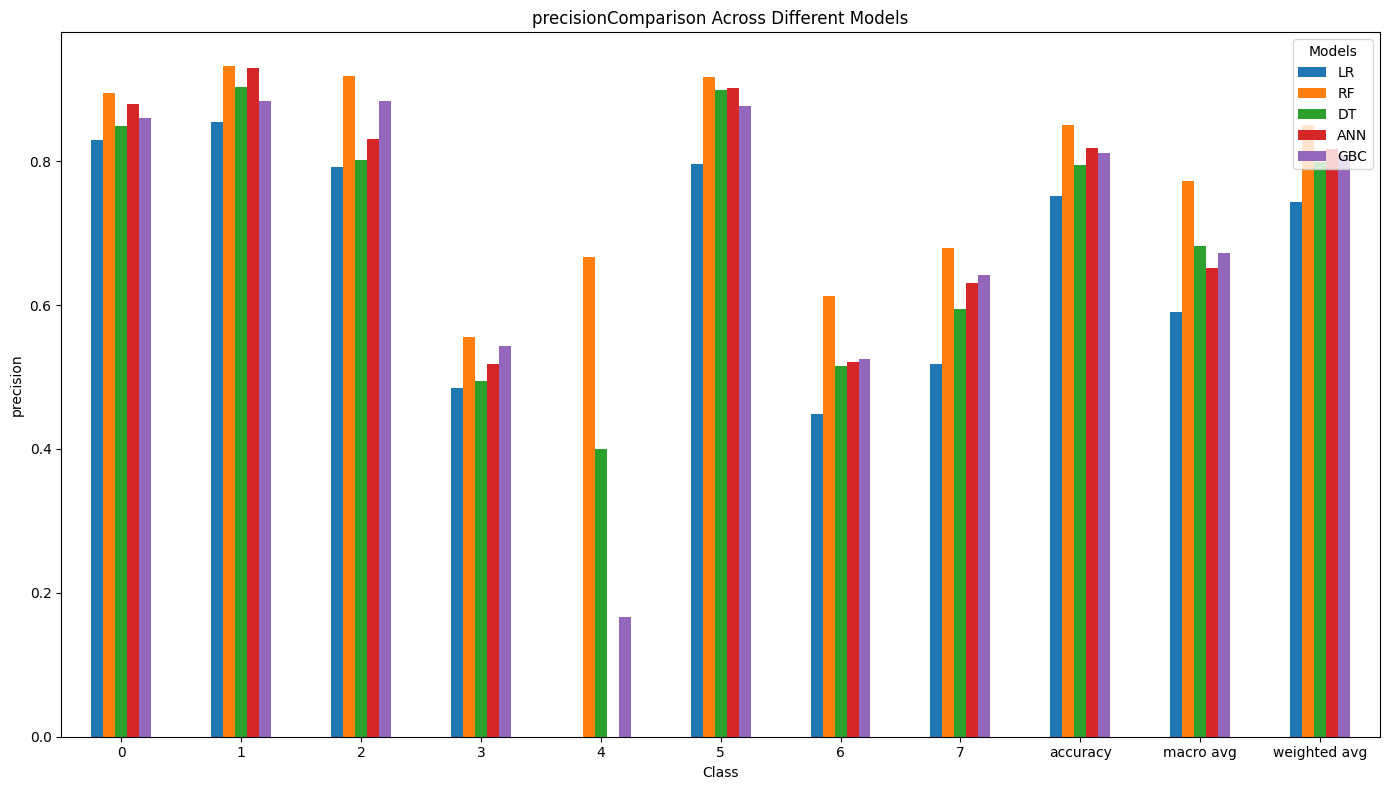

In [ ]:
combined_graphs(df_combined, 'precision')

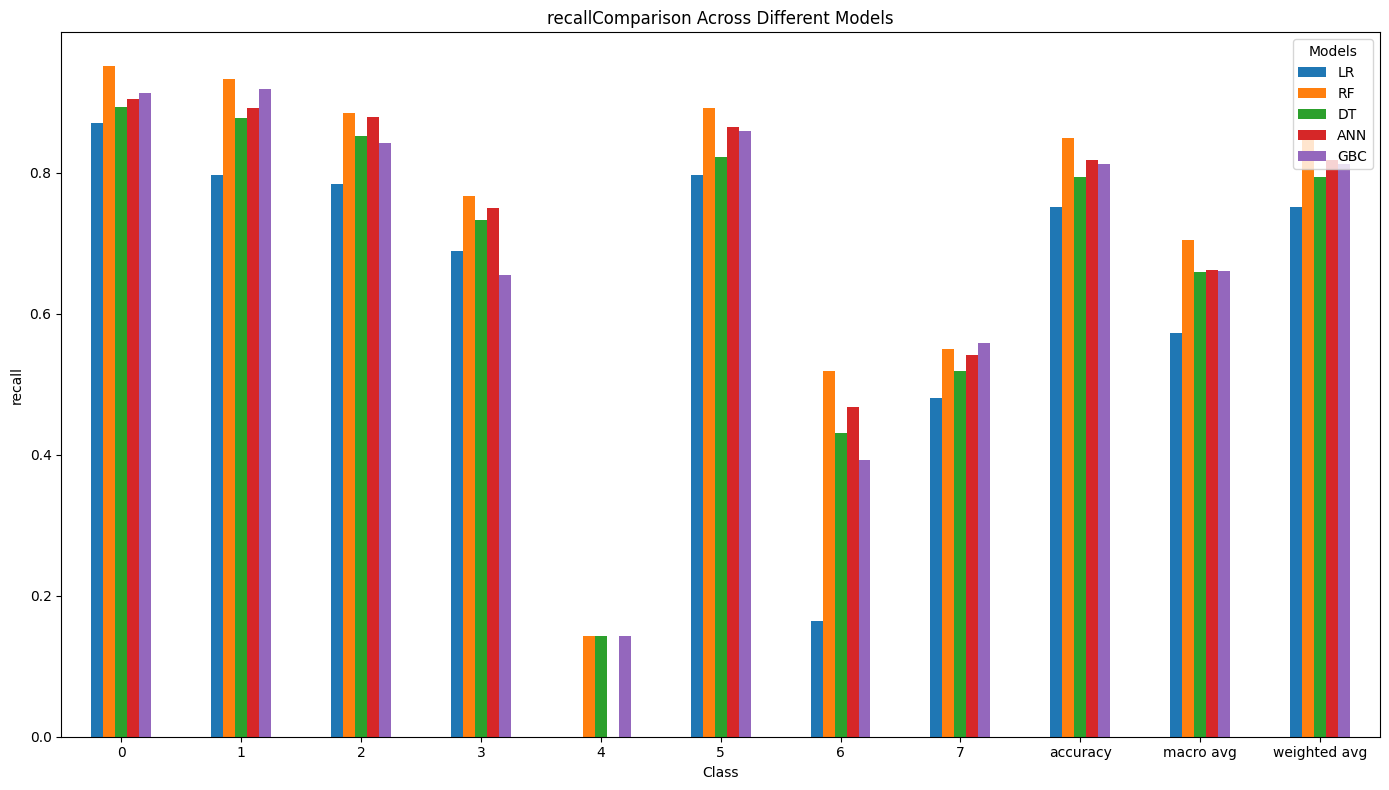

In [ ]:
combined_graphs(df_combined, 'recall')

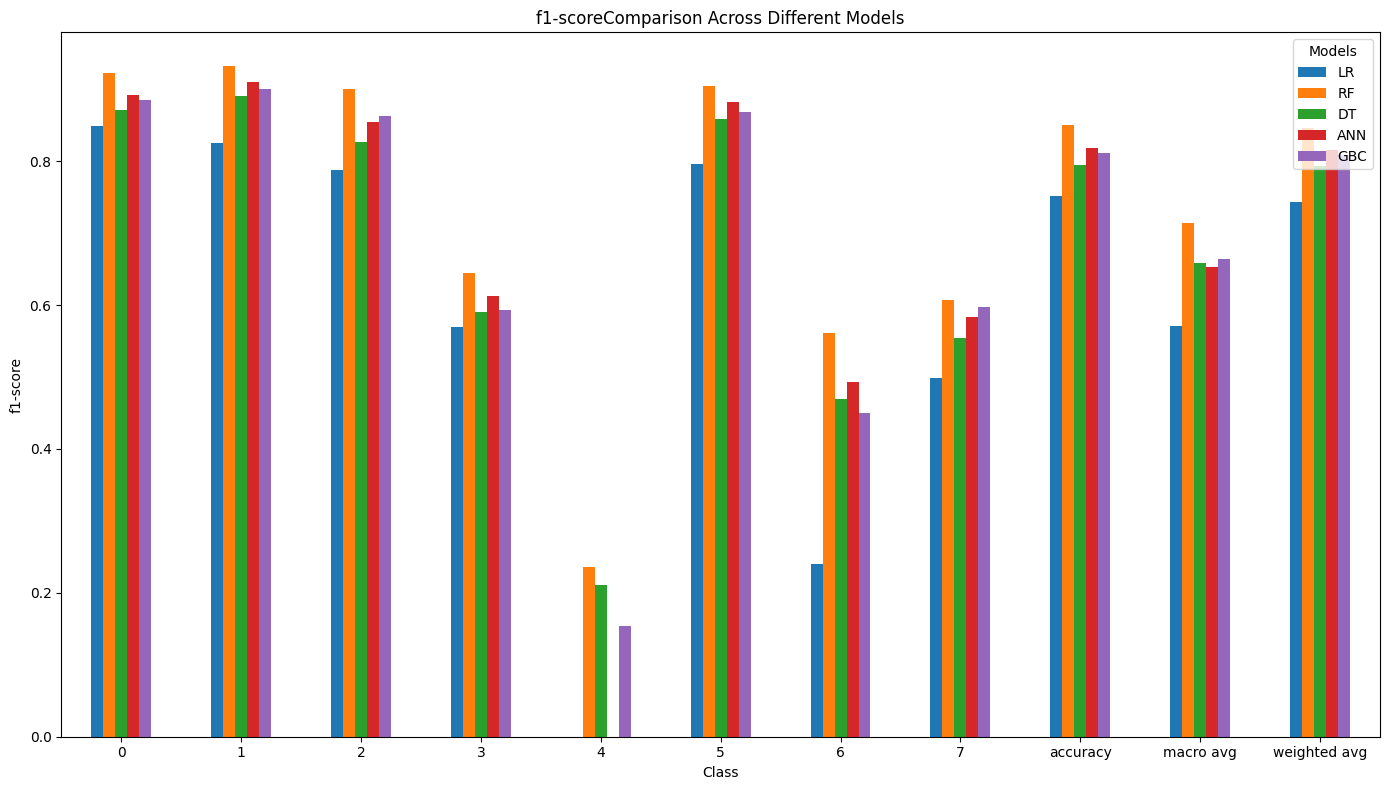

In [ ]:
combined_graphs(df_combined, 'f1-score')